# Data Exploration & Strategy Development

**Interactive Exploration of ES & NQ Futures Data**

This notebook provides interactive exploration and analysis tools for understanding:
1. **Price Dynamics** - Trends, volatility, and intraday patterns
2. **Noise Area Characteristics** - How boundaries adapt to market conditions
3. **Breakout Patterns** - What makes a successful vs failed breakout
4. **Transaction Cost Impact** - Visualizing the critical role of slippage

Use this notebook to develop intuition about the strategy and identify potential improvements.

---

## 1. Setup

In [56]:
import warnings
warnings.filterwarnings('ignore')
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import databento as db
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
import plotly.io as pio
pio.renderers.default = 'browser'
os.makedirs('results', exist_ok=True)
print("✓ Setup complete")

✓ Setup complete


## 2. Load Data

In [57]:
dbn_store = db.DBNStore.from_file("Data/GLBX-20260226-5NYJMUE93R/glbx-mdp3-20110101-20260225.ohlcv-1m.dbn")
NQ_df = dbn_store.to_df(schema="ohlcv-1m")
NQ_df.head(10)

,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
ts_event,,,,,,,,,
2011-01-02 23:00:00+00:00,33,1,93735,2220.00,2223.00,2220.00,2222.75,169,NQH1
2011-01-02 23:01:00+00:00,33,1,93735,2222.00,2222.75,2222.00,2222.25,10,NQH1
2011-01-02 23:02:00+00:00,33,1,93735,2222.25,2223.25,2222.00,2223.25,71,NQH1
2011-01-02 23:03:00+00:00,33,1,93735,2223.50,2223.50,2222.75,2223.00,70,NQH1
2011-01-02 23:04:00+00:00,33,1,93735,2223.25,2223.75,2223.00,2223.00,30,NQH1
2011-01-02 23:05:00+00:00,33,1,93735,2223.00,2223.25,2222.00,2222.00,53,NQH1
2011-01-02 23:06:00+00:00,33,1,93735,2221.75,2221.75,2221.50,2221.50,12,NQH1
2011-01-02 23:07:00+00:00,33,1,93735,2221.75,2222.00,2221.50,2221.50,58,NQH1
2011-01-02 23:08:00+00:00,33,1,93735,2221.25,2221.25,2220.50,2220.75,54,NQH1


In [58]:
dbn_store = db.DBNStore.from_file("Data/GLBX-20260226-Y3FV3LYH44/glbx-mdp3-20110101-20260225.ohlcv-1m.dbn")
ES_df = dbn_store.to_df(schema="ohlcv-1m")
ES_df.head(10)

,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
ts_event,,,,,,,,,
2011-01-02 23:00:00+00:00,33,1,70248,1256.00,1257.00,1255.25,1256.75,1766,ESH1
2011-01-02 23:01:00+00:00,33,1,70248,1256.75,1257.00,1256.50,1256.75,259,ESH1
2011-01-02 23:02:00+00:00,33,1,70248,1256.50,1257.25,1256.50,1257.00,513,ESH1
2011-01-02 23:03:00+00:00,33,1,70248,1257.25,1257.50,1257.00,1257.25,495,ESH1
2011-01-02 23:03:00+00:00,33,1,49278,1248.00,1248.00,1248.00,1248.00,5,ESU1
2011-01-02 23:04:00+00:00,33,1,70248,1257.25,1257.75,1257.25,1257.25,489,ESH1
2011-01-02 23:05:00+00:00,33,1,70248,1257.25,1257.25,1257.00,1257.00,121,ESH1
2011-01-02 23:06:00+00:00,33,1,70248,1257.00,1257.00,1256.75,1256.75,36,ESH1
2011-01-02 23:07:00+00:00,33,1,70248,1256.75,1257.00,1256.75,1256.75,216,ESH1


In [59]:
# Find columns of the datasets
print("ES Columns:", ES_df.columns.tolist())
print("NQ Columns:", NQ_df.columns.tolist())

ES Columns: ['rtype', 'publisher_id', 'instrument_id', 'open', 'high', 'low', 'close', 'volume', 'symbol']
NQ Columns: ['rtype', 'publisher_id', 'instrument_id', 'open', 'high', 'low', 'close', 'volume', 'symbol']


In [60]:
def process_databento_ohlcv(df, symbol_name='ES'):
    """
    Transform Databento OHLCV data to strategy-ready format.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw Databento data with columns: rtype, publisher_id, instrument_id, 
        open, high, low, close, volume, symbol
    symbol_name : str
        Symbol name for logging (ES or NQ)
    
    Returns
    -------
    pd.DataFrame
        Processed data with standard OHLCV columns, 5-min bars, RTH only
    """
    print(f"Processing {symbol_name} data...")
    print(f"  Raw data shape: {df.shape}")
    print(f"  Raw columns: {df.columns.tolist()}")
    
    # 1. RENAME COLUMNS to standard format
    df_proc = df.copy()
    df_proc = df_proc.rename(columns={
        'open': 'Open',
        'high': 'High', 
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    })
    
    # 2. ENSURE DATETIME INDEX in ET timezone
    if not isinstance(df_proc.index, pd.DatetimeIndex):
        df_proc.index = pd.to_datetime(df_proc.index)
    
    # Convert to ET timezone (crucial for RTH filtering)
    if df_proc.index.tz is None:
        df_proc.index = df_proc.index.tz_localize('UTC')
    df_proc.index = df_proc.index.tz_convert('America/New_York')
    
    # 3. FILTER TO REGULAR TRADING HOURS (RTH: 9:30 AM - 4:00 PM ET)
    df_proc['hour'] = df_proc.index.hour
    df_proc['minute'] = df_proc.index.minute
    
    rth_filter = (
        ((df_proc['hour'] == 9) & (df_proc['minute'] >= 30)) |
        ((df_proc['hour'] >= 10) & (df_proc['hour'] < 16)) |
        ((df_proc['hour'] == 16) & (df_proc['minute'] == 0))
    )
    df_proc = df_proc[rth_filter].copy()
    df_proc = df_proc.drop(['hour', 'minute'], axis=1)
    
    print(f"  After RTH filter: {df_proc.shape}")
    
    # 4. RESAMPLE 1-minute to 5-minute bars
    # Use proper OHLC aggregation
    df_5min = df_proc[['Open', 'High', 'Low', 'Close', 'Volume']].resample('5min').agg({
        'Open': 'first',    # First open in 5-min window
        'High': 'max',      # Highest high
        'Low': 'min',       # Lowest low
        'Close': 'last',    # Last close
        'Volume': 'sum'     # Total volume
    })
    
    # Drop rows with NaN (partial bars at edges)
    df_5min = df_5min.dropna()
    
    print(f"  After 5-min resample: {df_5min.shape}")
    
    # 5. HANDLE MISSING VALUES & DATA QUALITY
    # Check for gaps in data
    expected_bars_per_day = 78  # (6.5 hours * 60 min) / 5 min = 78 bars
    dates = df_5min.index.date
    unique_dates = pd.Series(dates).value_counts()
    
    print(f"  Date range: {df_5min.index.min()} to {df_5min.index.max()}")
    print(f"  Trading days: {len(unique_dates)}")
    print(f"  Avg bars/day: {unique_dates.mean():.1f} (expected: {expected_bars_per_day})")
    
    # Remove days with too few bars (likely half-days or data gaps)
    min_bars_threshold = 50  # At least 50 bars/day
    valid_dates = set(unique_dates[unique_dates >= min_bars_threshold].index)
    df_5min = df_5min[[d in valid_dates for d in df_5min.index.date]]
    
    print(f"  After removing incomplete days: {df_5min.shape}")
    
    # 6. VALIDATE DATA INTEGRITY
    # Check for zero/negative prices or volume
    invalid_rows = (
        (df_5min['Open'] <= 0) | 
        (df_5min['High'] <= 0) | 
        (df_5min['Low'] <= 0) | 
        (df_5min['Close'] <= 0) |
        (df_5min['Volume'] < 0)
    )
    
    if invalid_rows.sum() > 0:
        print(f"  WARNING: Removing {invalid_rows.sum()} rows with invalid prices/volume")
        df_5min = df_5min[~invalid_rows]
    
    # Check for High < Low inconsistencies
    invalid_hl = df_5min['High'] < df_5min['Low']
    if invalid_hl.sum() > 0:
        print(f"  WARNING: Fixing {invalid_hl.sum()} rows where High < Low")
        # Swap them
        df_5min.loc[invalid_hl, ['High', 'Low']] = df_5min.loc[invalid_hl, ['Low', 'High']].values
    
    # 7. ADD DERIVED FEATURES
    df_5min['Returns'] = df_5min['Close'].pct_change()
    df_5min['Log_Returns'] = np.log(df_5min['Close'] / df_5min['Close'].shift(1))
    df_5min['Range'] = df_5min['High'] - df_5min['Low']
    df_5min['Range_Pct'] = df_5min['Range'] / df_5min['Close']
    df_5min['Intraday_Return'] = (df_5min['Close'] - df_5min['Open']) / df_5min['Open']
    
    print(f"\n✓ {symbol_name} processing complete!")
    print(f"  Final shape: {df_5min.shape}")
    print(f"  Final columns: {df_5min.columns.tolist()}")
    
    return df_5min

# Filter to outright contracts only (exclude spreads)
ES_outright = ES_df[~ES_df['symbol'].str.contains('-')]
NQ_outright = NQ_df[~NQ_df['symbol'].str.contains('-')]

print(f"ES outright shape: {ES_outright.shape}")
print(f"NQ outright shape: {NQ_outright.shape}")

# Process both ES and NQ
es_data = process_databento_ohlcv(ES_outright, 'ES')
nq_data = process_databento_ohlcv(NQ_outright, 'NQ')

ES outright shape: (7271509, 9)
NQ outright shape: (6284645, 9)
Processing ES data...
  Raw data shape: (7271509, 9)
  Raw columns: ['rtype', 'publisher_id', 'instrument_id', 'open', 'high', 'low', 'close', 'volume', 'symbol']
  After RTH filter: (2420975, 9)
  After 5-min resample: (302638, 5)
  Date range: 2011-01-03 09:30:00-05:00 to 2026-02-25 16:00:00-05:00
  Trading days: 3890
  Avg bars/day: 77.8 (expected: 78)
  After removing incomplete days: (297665, 5)

✓ ES processing complete!
  Final shape: (297665, 10)
  Final columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Log_Returns', 'Range', 'Range_Pct', 'Intraday_Return']
Processing NQ data...
  Raw data shape: (6284645, 9)
  Raw columns: ['rtype', 'publisher_id', 'instrument_id', 'open', 'high', 'low', 'close', 'volume', 'symbol']
  After RTH filter: (2045809, 9)
  After 5-min resample: (302635, 5)
  Date range: 2011-01-03 09:30:00-05:00 to 2026-02-25 16:00:00-05:00
  Trading days: 3890
  Avg bars/day: 77.8 (expect

In [61]:
es_low_below_60 = es_data[es_data['Low'] < 60]
print(f"ES bars with Low < 60: {len(es_low_below_60)}")
nq_low_below_60 = nq_data[nq_data['Low'] < 60]
print(f"NQ bars with Low < 60: {len(nq_low_below_60)}")

ES bars with Low < 60: 0
NQ bars with Low < 60: 0


## 2.2 Data Quality Checks & Visualization

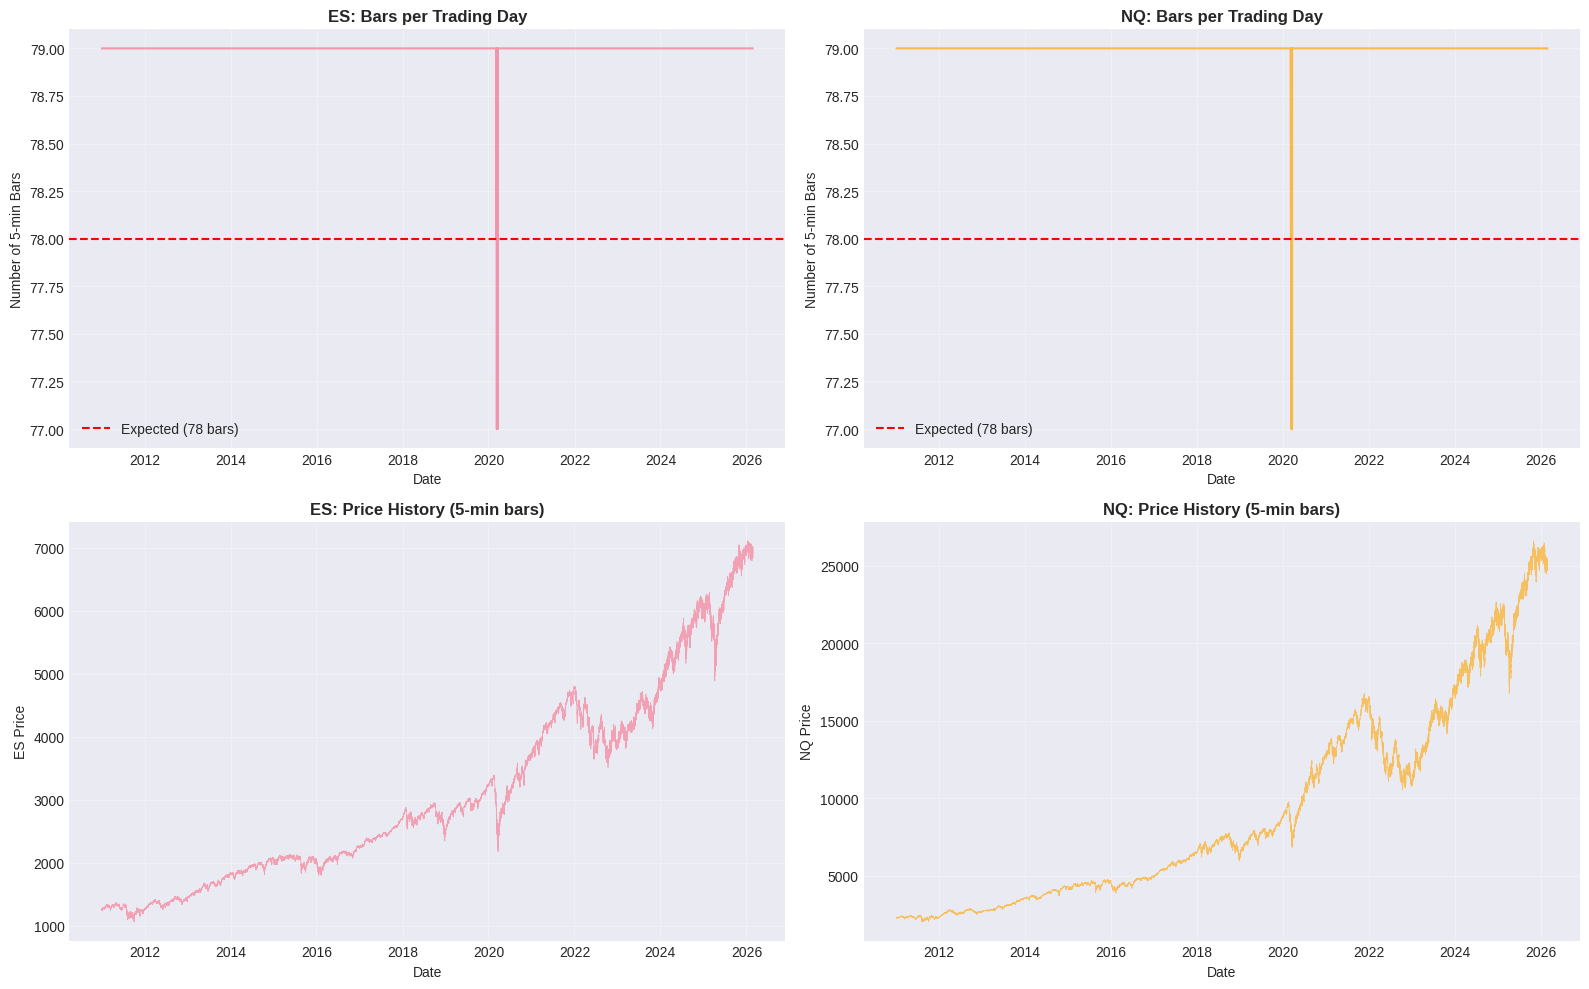

✓ Data quality visualization saved to results/data_quality_check.png


In [62]:
# Visualize data gaps and trading days per year
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ES: Bars per day over time
ax = axes[0, 0]
es_daily_bars = es_data.groupby(es_data.index.date).size()
ax.plot(es_daily_bars.index, es_daily_bars.values, alpha=0.7)
ax.axhline(y=78, color='red', linestyle='--', label='Expected (78 bars)')
ax.set_title('ES: Bars per Trading Day', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Number of 5-min Bars')
ax.legend()
ax.grid(True, alpha=0.3)

# NQ: Bars per day over time
ax = axes[0, 1]
nq_daily_bars = nq_data.groupby(nq_data.index.date).size()
ax.plot(nq_daily_bars.index, nq_daily_bars.values, alpha=0.7, color='orange')
ax.axhline(y=78, color='red', linestyle='--', label='Expected (78 bars)')
ax.set_title('NQ: Bars per Trading Day', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Number of 5-min Bars')
ax.legend()
ax.grid(True, alpha=0.3)

# ES: Price over time
ax = axes[1, 0]
ax.plot(es_data.index, es_data['Close'], alpha=0.6, linewidth=0.5)
ax.set_title('ES: Price History (5-min bars)', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('ES Price')
ax.grid(True, alpha=0.3)

# NQ: Price over time
ax = axes[1, 1]
ax.plot(nq_data.index, nq_data['Close'], alpha=0.6, linewidth=0.5, color='orange')
ax.set_title('NQ: Price History (5-min bars)', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('NQ Price')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/data_quality_check.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Data quality visualization saved to results/data_quality_check.png")

In [63]:
# Save processed data for use in backtesting
os.makedirs('Data', exist_ok=True)
es_data.to_csv('Data/ES_5min_RTH.csv')
nq_data.to_csv('Data/NQ_5min_RTH.csv')
print("✓ Processed data saved:")
print(f"  - Data/ES_5min_RTH.csv ({len(es_data)} bars)")
print(f"  - Data/NQ_5min_RTH.csv ({len(nq_data)} bars)")

✓ Processed data saved:
  - Data/ES_5min_RTH.csv (297665 bars)
  - Data/NQ_5min_RTH.csv (297665 bars)


## 3. Basic Statistics & Distributions

In [80]:
# Calculate returns
es_data['returns'] = es_data['Close'].pct_change()
nq_data['returns'] = nq_data['Close'].pct_change()

# Summary statistics
print("="*60)
print("ES STATISTICS")
print("="*60)
print(es_data[['Open', 'High', 'Low', 'Close', 'Volume']].describe())
print(f"\nReturns:")
print(f"  Mean: {es_data['returns'].mean()*100:.4f}%")
print(f"  Std Dev: {es_data['returns'].std()*100:.4f}%")
print(f"  Skewness: {es_data['returns'].skew():.3f}")
print(f"  Kurtosis: {es_data['returns'].kurtosis():.3f}")

print("\n" + "="*60)
print("NQ STATISTICS")
print("="*60)
print(nq_data[['Open', 'High', 'Low', 'Close', 'Volume']].describe())
print(f"\nReturns:")
print(f"  Mean: {nq_data['returns'].mean()*100:.4f}%")
print(f"  Std Dev: {nq_data['returns'].std()*100:.4f}%")
print(f"  Skewness: {nq_data['returns'].skew():.3f}")
print(f"  Kurtosis: {nq_data['returns'].kurtosis():.3f}")

ES STATISTICS
                Open           High            Low          Close  \
count  297665.000000  297665.000000  297665.000000  297665.000000   
mean     3108.591579    3120.778530    3100.472339    3109.009669   
std      1517.950492    1530.999671    1513.376923    1518.470126   
min      1062.250000    1073.000000    1062.250000    1067.500000   
25%      1947.250000    1951.500000    1939.750000    1947.500000   
50%      2726.250000    2731.500000    2723.000000    2726.500000   
75%      4177.250000    4193.500000    4165.500000    4177.250000   
max      7122.000000    7126.750000    7023.250000    7110.000000   

              Volume  
count  297665.000000  
mean    16712.476102  
std     14031.642568  
min       124.000000  
25%      8007.000000  
50%     12830.000000  
75%     20778.000000  
max    355751.000000  

Returns:
  Mean: 0.0013%
  Std Dev: 0.3858%
  Skewness: -0.016
  Kurtosis: 8.531

NQ STATISTICS
                Open           High            Low          

### Return Distributions

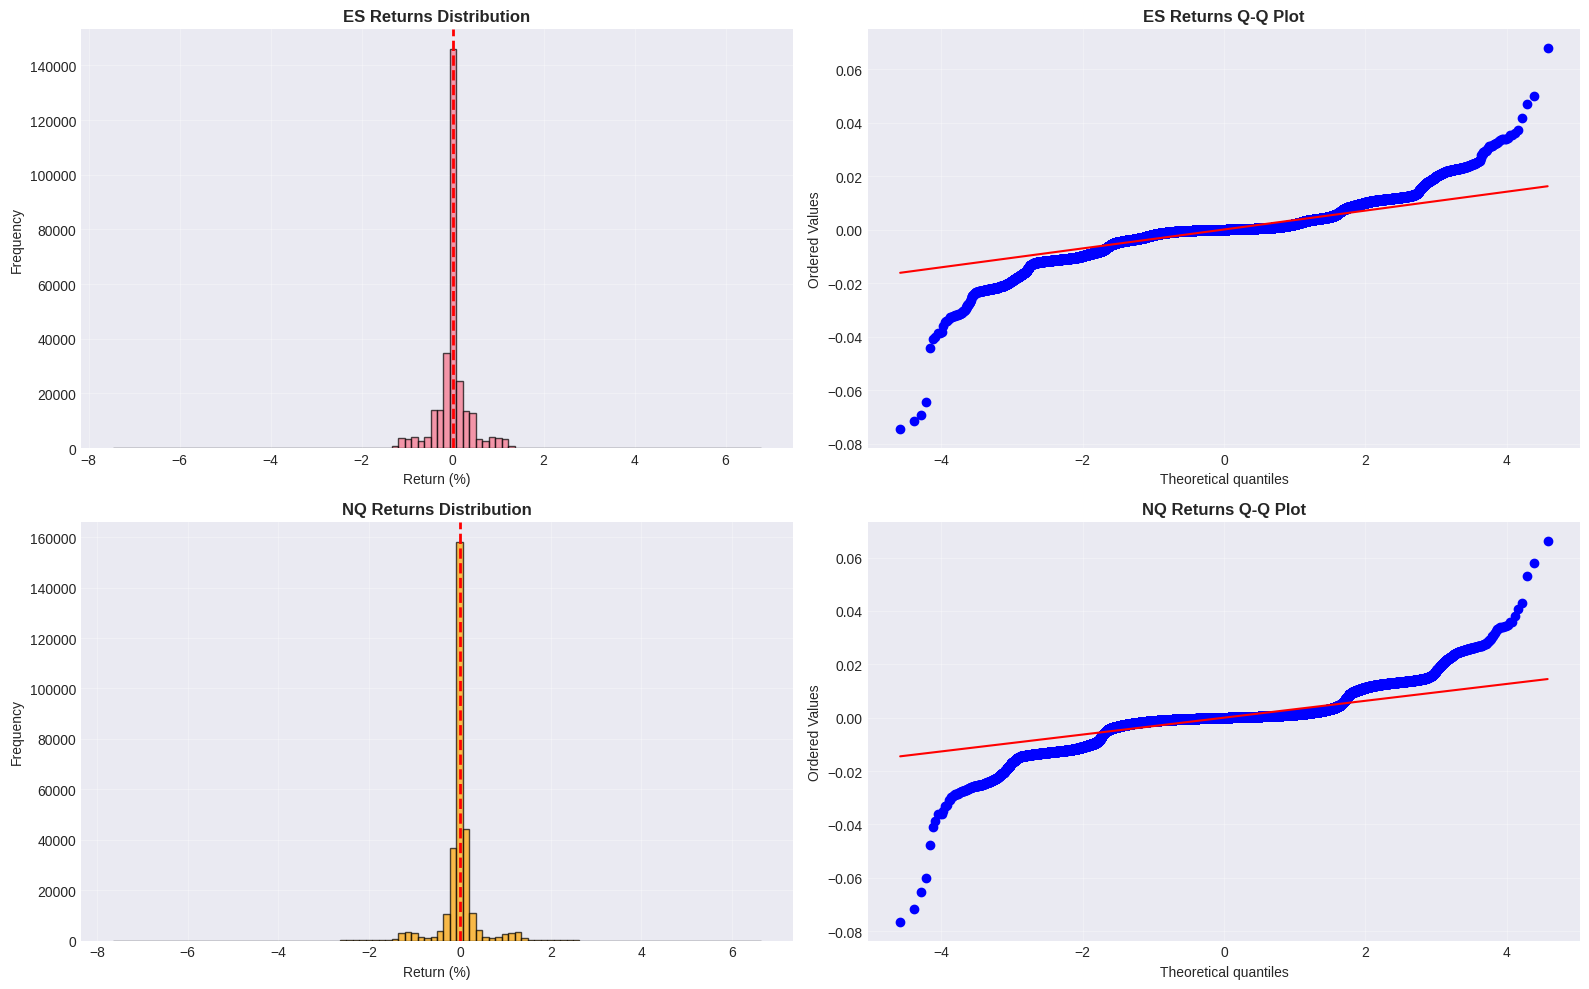

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ES returns histogram
ax = axes[0, 0]
ax.hist(es_data['returns'].dropna()*100, bins=100, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.set_title('ES Returns Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Return (%)')
ax.set_ylabel('Frequency')
ax.grid(True, alpha=0.3)

# ES returns Q-Q plot
ax = axes[0, 1]
from scipy import stats
stats.probplot(es_data['returns'].dropna(), dist="norm", plot=ax)
ax.set_title('ES Returns Q-Q Plot', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# NQ returns histogram
ax = axes[1, 0]
ax.hist(nq_data['returns'].dropna()*100, bins=100, alpha=0.7, edgecolor='black', color='orange')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.set_title('NQ Returns Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Return (%)')
ax.set_ylabel('Frequency')
ax.grid(True, alpha=0.3)

# NQ returns Q-Q plot
ax = axes[1, 1]
stats.probplot(nq_data['returns'].dropna(), dist="norm", plot=ax)
ax.set_title('NQ Returns Q-Q Plot', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/exploration_return_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Intraday Patterns

Analyze time-of-day effects.

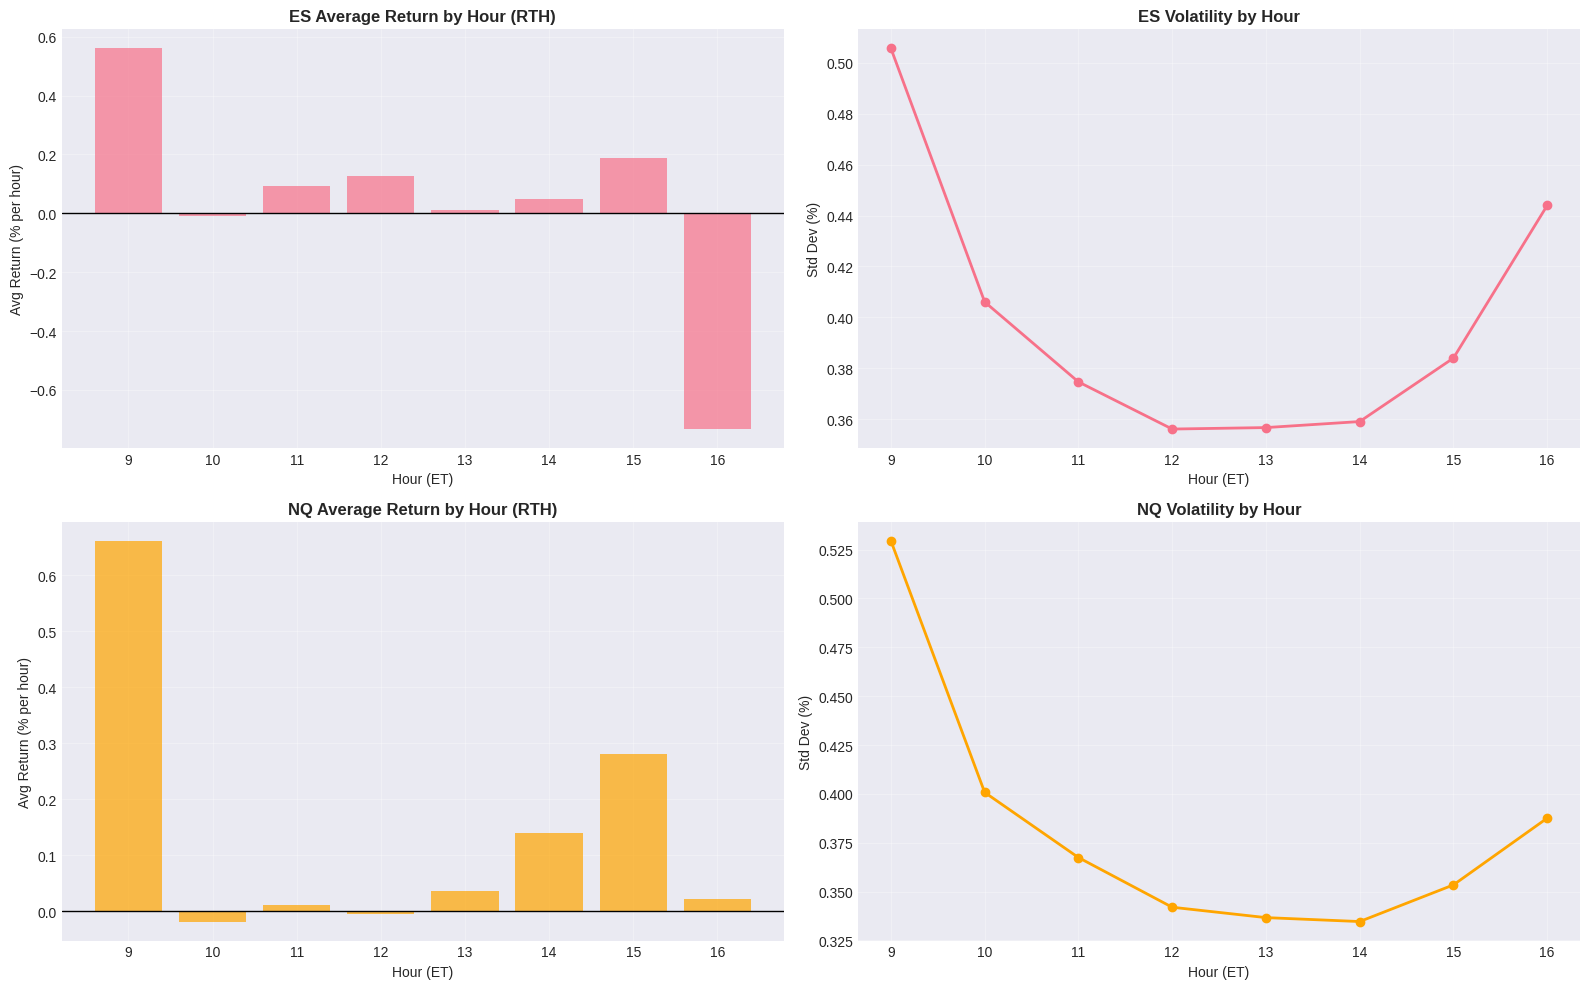

Key Observations:
  ES most volatile hour: 9:00
  NQ most volatile hour: 9:00


In [66]:
# Extract hour and minute
es_data['hour'] = es_data.index.hour
es_data['minute'] = es_data.index.minute
nq_data['hour'] = nq_data.index.hour
nq_data['minute'] = nq_data.index.minute

# Calculate average return and volatility by hour
es_hourly = es_data.groupby('hour').agg({
    'returns': ['mean', 'std', 'count'],
    'Volume': 'mean'
})

nq_hourly = nq_data.groupby('hour').agg({
    'returns': ['mean', 'std', 'count'],
    'Volume': 'mean'
})

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ES hourly returns
ax = axes[0, 0]
ax.bar(es_hourly.index, es_hourly['returns']['mean']*100*78, alpha=0.7)  # Annualized
ax.axhline(y=0, color='black', linewidth=1)
ax.set_title('ES Average Return by Hour (RTH)', fontsize=12, fontweight='bold')
ax.set_xlabel('Hour (ET)')
ax.set_ylabel('Avg Return (% per hour)')
ax.set_xticks(range(9, 17))
ax.grid(True, alpha=0.3)

# ES hourly volatility
ax = axes[0, 1]
ax.plot(es_hourly.index, es_hourly['returns']['std']*100, marker='o', linewidth=2)
ax.set_title('ES Volatility by Hour', fontsize=12, fontweight='bold')
ax.set_xlabel('Hour (ET)')
ax.set_ylabel('Std Dev (%)')
ax.set_xticks(range(9, 17))
ax.grid(True, alpha=0.3)

# NQ hourly returns
ax = axes[1, 0]
ax.bar(nq_hourly.index, nq_hourly['returns']['mean']*100*78, alpha=0.7, color='orange')
ax.axhline(y=0, color='black', linewidth=1)
ax.set_title('NQ Average Return by Hour (RTH)', fontsize=12, fontweight='bold')
ax.set_xlabel('Hour (ET)')
ax.set_ylabel('Avg Return (% per hour)')
ax.set_xticks(range(9, 17))
ax.grid(True, alpha=0.3)

# NQ hourly volatility
ax = axes[1, 1]
ax.plot(nq_hourly.index, nq_hourly['returns']['std']*100, marker='o', linewidth=2, color='orange')
ax.set_title('NQ Volatility by Hour', fontsize=12, fontweight='bold')
ax.set_xlabel('Hour (ET)')
ax.set_ylabel('Std Dev (%)')
ax.set_xticks(range(9, 17))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/exploration_intraday_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("Key Observations:")
print(f"  ES most volatile hour: {es_hourly['returns']['std'].idxmax()}:00")
print(f"  NQ most volatile hour: {nq_hourly['returns']['std'].idxmax()}:00")

## 5. Volatility Dynamics

Analyze how volatility changes over time (important for noise area calculation).

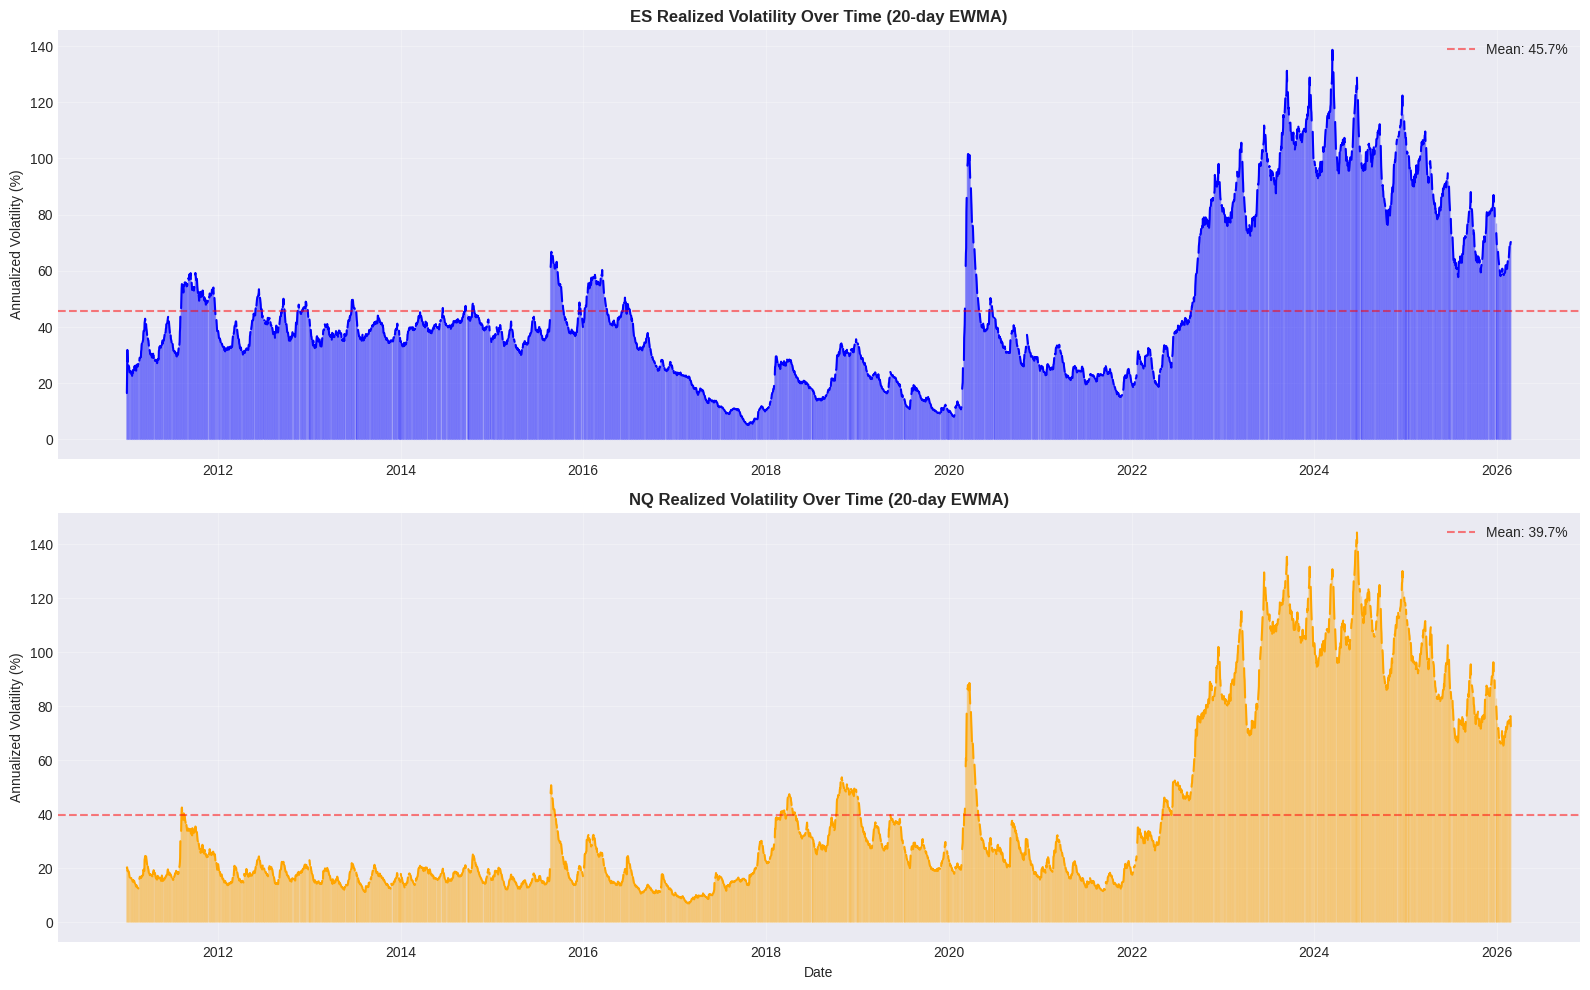


Volatility Statistics:
  ES mean vol: 45.71%
  ES vol range: 5.17% - 138.68%
  NQ mean vol: 39.71%
  NQ vol range: 6.92% - 144.36%


In [67]:
# Calculate rolling volatility (20-day EWMA)
es_data['vol_ewma'] = es_data['returns'].ewm(span=20*78, adjust=False).std() * np.sqrt(252*78)  # Annualized
nq_data['vol_ewma'] = nq_data['returns'].ewm(span=20*78, adjust=False).std() * np.sqrt(252*78)

# Resample to daily for cleaner visualization
es_daily_vol = es_data['vol_ewma'].resample('D').last()
nq_daily_vol = nq_data['vol_ewma'].resample('D').last()

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ES volatility over time
ax = axes[0]
ax.plot(es_daily_vol.index, es_daily_vol*100, linewidth=1.5, color='blue')
ax.fill_between(es_daily_vol.index, 0, es_daily_vol*100, alpha=0.3, color='blue')
ax.axhline(y=es_daily_vol.mean()*100, color='red', linestyle='--', alpha=0.5, 
           label=f'Mean: {es_daily_vol.mean()*100:.1f}%')
ax.set_title('ES Realized Volatility Over Time (20-day EWMA)', fontsize=12, fontweight='bold')
ax.set_ylabel('Annualized Volatility (%)')
ax.legend()
ax.grid(True, alpha=0.3)

# NQ volatility over time
ax = axes[1]
ax.plot(nq_daily_vol.index, nq_daily_vol*100, linewidth=1.5, color='orange')
ax.fill_between(nq_daily_vol.index, 0, nq_daily_vol*100, alpha=0.3, color='orange')
ax.axhline(y=nq_daily_vol.mean()*100, color='red', linestyle='--', alpha=0.5,
           label=f'Mean: {nq_daily_vol.mean()*100:.1f}%')
ax.set_title('NQ Realized Volatility Over Time (20-day EWMA)', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Annualized Volatility (%)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/exploration_volatility_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVolatility Statistics:")
print(f"  ES mean vol: {es_daily_vol.mean()*100:.2f}%")
print(f"  ES vol range: {es_daily_vol.min()*100:.2f}% - {es_daily_vol.max()*100:.2f}%")
print(f"  NQ mean vol: {nq_daily_vol.mean()*100:.2f}%")
print(f"  NQ vol range: {nq_daily_vol.min()*100:.2f}% - {nq_daily_vol.max()*100:.2f}%")

## 6. Noise Area Exploration

Calculate and visualize noise area with different parameters.

In [68]:
# Load configuration and import noise area calculator
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Import noise area calculator
import sys
sys.path.insert(0, '.')
from noise_area import NoiseAreaCalculator

print("✓ Configuration loaded")
print("✓ NoiseAreaCalculator imported")

✓ Configuration loaded
✓ NoiseAreaCalculator imported


In [75]:
start_date = pd.Timestamp('2011-02-01', tz='America/New_York')
start_idx = es_test.index.get_loc(es_test.index[es_test.index >= start_date].min())
plot_data = es_test.iloc[start_idx:start_idx + min(1000, len(es_test) - start_idx)]

## 7. Breakout Success Rate Analysis

Analyze characteristics of successful vs failed breakouts.

NOISE AREA CALCULATION
Calculating noise area using percentile method (30 days)...
  Filtered 5.9% outlier days (range > 135.75)
  Calculated noise area for 297665 bars
  Avg upper range: 46.41
  Avg lower range: 37.12

Validation:
  Valid boundaries: 99.6%
  Avg boundary width: 83.53
BREAKOUT ANALYSIS
Total breakouts: 3659
Successful: 2611 (71.4%)
Failed: 1048 (28.6%)

Average P&L:
  Successful: $23.78
  Failed: $-3.91

Average Duration:
  Successful: 1.3 bars
  Failed: 1.4 bars


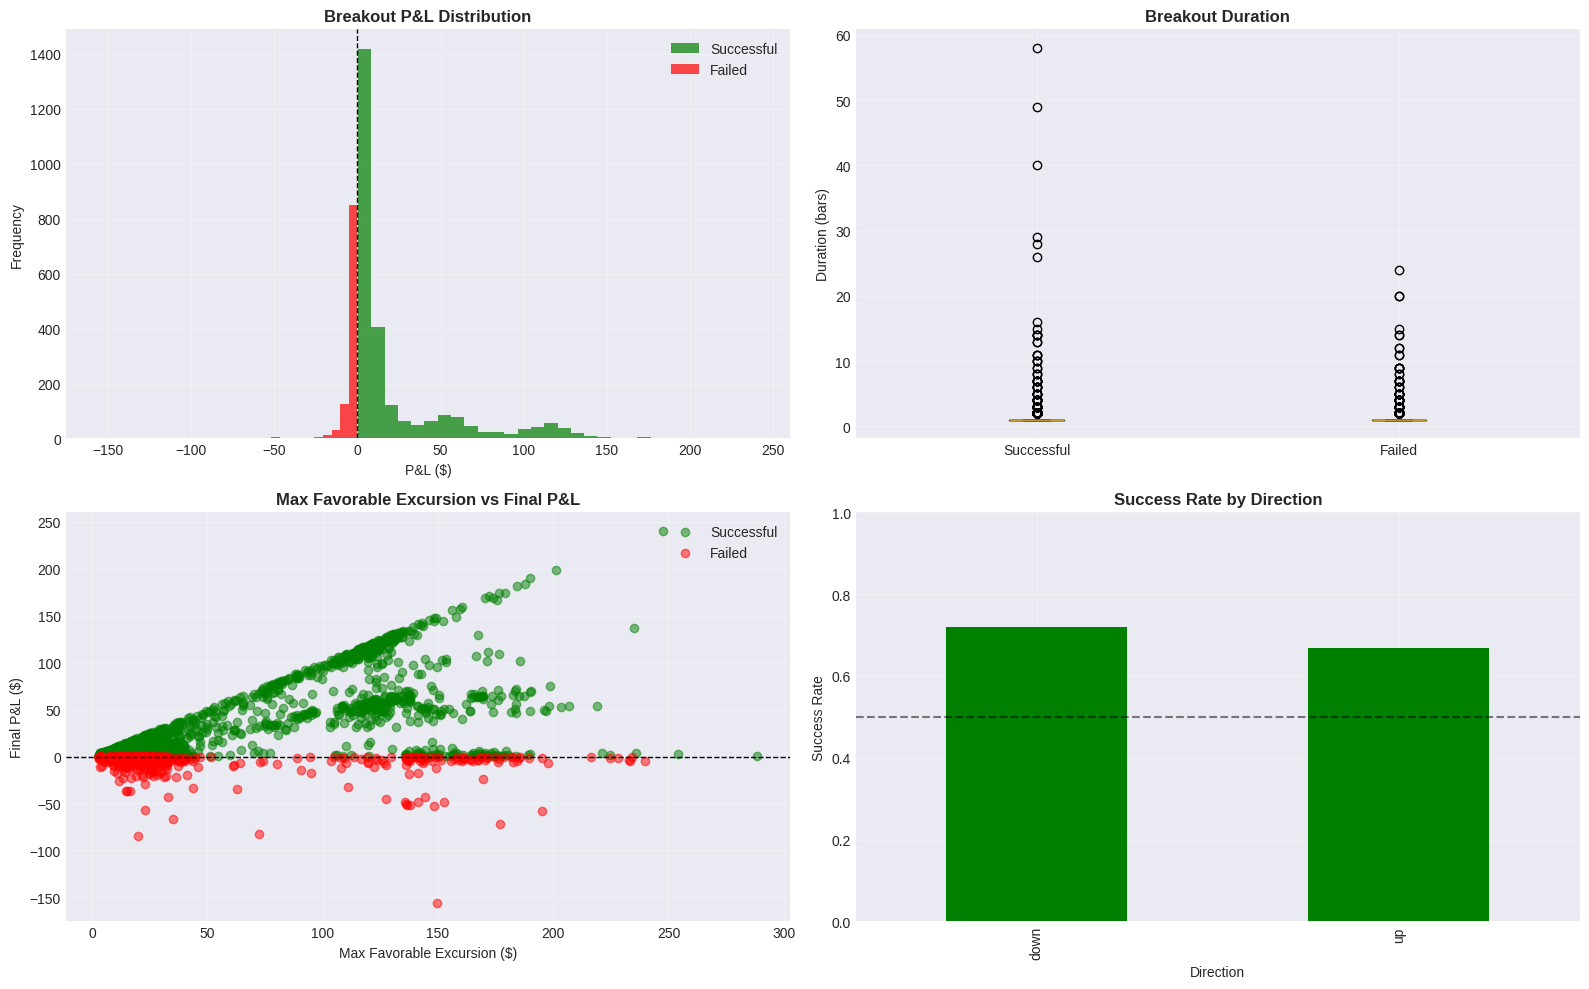


✓ Breakout analysis saved


In [76]:
# Calculate noise area with base config
calculator = NoiseAreaCalculator(config)
es_analysis = calculator.calculate_noise_area(es_data.copy())
es_analysis = calculator.identify_breakouts(es_analysis)

# Identify breakout episodes
breakouts = []
in_breakout = False
breakout_start = None
breakout_high = None
breakout_low = None
breakout_direction = None

for i in range(len(es_analysis)):
    row = es_analysis.iloc[i]
    
    if (row['break_above'] or row['break_below']) and not in_breakout:
        # Start of breakout
        in_breakout = True
        breakout_start = i
        breakout_high = row['High']
        breakout_low = row['Low']
        breakout_direction = 'up' if row['break_above'] else 'down'
    
    elif in_breakout:
        # Update highs/lows during breakout
        breakout_high = max(breakout_high, row['High'])
        breakout_low = min(breakout_low, row['Low'])
        
        # Check for end of breakout (re-enters noise area)
        if row['inside_noise']:
            # End of breakout - record it
            entry_price = es_analysis.iloc[breakout_start]['Close']
            exit_price = row['Close']
            
            if breakout_direction == 'up':
                pnl = exit_price - entry_price
                max_favorable = breakout_high - entry_price
            else:
                pnl = entry_price - exit_price
                max_favorable = entry_price - breakout_low
            
            breakouts.append({
                'start_idx': breakout_start,
                'end_idx': i,
                'direction': breakout_direction,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'pnl': pnl,
                'max_favorable': max_favorable,
                'duration_bars': i - breakout_start,
                'success': pnl > 0
            })
            
            in_breakout = False

df_breakouts = pd.DataFrame(breakouts)

if len(df_breakouts) > 0:
    print("="*60)
    print("BREAKOUT ANALYSIS")
    print("="*60)
    print(f"Total breakouts: {len(df_breakouts)}")
    print(f"Successful: {df_breakouts['success'].sum()} ({df_breakouts['success'].mean()*100:.1f}%)")
    print(f"Failed: {(~df_breakouts['success']).sum()} ({(~df_breakouts['success']).mean()*100:.1f}%)")
    print(f"\nAverage P&L:")
    print(f"  Successful: ${df_breakouts[df_breakouts['success']]['pnl'].mean():.2f}")
    print(f"  Failed: ${df_breakouts[~df_breakouts['success']]['pnl'].mean():.2f}")
    print(f"\nAverage Duration:")
    print(f"  Successful: {df_breakouts[df_breakouts['success']]['duration_bars'].mean():.1f} bars")
    print(f"  Failed: {df_breakouts[~df_breakouts['success']]['duration_bars'].mean():.1f} bars")
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # P&L distribution
    ax = axes[0, 0]
    ax.hist(df_breakouts[df_breakouts['success']]['pnl'], bins=30, alpha=0.7, 
            label='Successful', color='green')
    ax.hist(df_breakouts[~df_breakouts['success']]['pnl'], bins=30, alpha=0.7,
            label='Failed', color='red')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.set_title('Breakout P&L Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('P&L ($)')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Duration comparison
    ax = axes[0, 1]
    ax.boxplot([df_breakouts[df_breakouts['success']]['duration_bars'],
                df_breakouts[~df_breakouts['success']]['duration_bars']],
               labels=['Successful', 'Failed'])
    ax.set_title('Breakout Duration', fontsize=12, fontweight='bold')
    ax.set_ylabel('Duration (bars)')
    ax.grid(True, alpha=0.3)
    
    # Max favorable excursion
    ax = axes[1, 0]
    ax.scatter(df_breakouts[df_breakouts['success']]['max_favorable'],
              df_breakouts[df_breakouts['success']]['pnl'],
              alpha=0.5, color='green', label='Successful')
    ax.scatter(df_breakouts[~df_breakouts['success']]['max_favorable'],
              df_breakouts[~df_breakouts['success']]['pnl'],
              alpha=0.5, color='red', label='Failed')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.set_title('Max Favorable Excursion vs Final P&L', fontsize=12, fontweight='bold')
    ax.set_xlabel('Max Favorable Excursion ($)')
    ax.set_ylabel('Final P&L ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Success rate by direction
    ax = axes[1, 1]
    direction_success = df_breakouts.groupby('direction')['success'].agg(['sum', 'count', 'mean'])
    direction_success['mean'].plot(kind='bar', ax=ax, color=['green' if x > 0.5 else 'red' 
                                                              for x in direction_success['mean']])
    ax.set_title('Success Rate by Direction', fontsize=12, fontweight='bold')
    ax.set_xlabel('Direction')
    ax.set_ylabel('Success Rate')
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/exploration_breakout_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Save breakout data
    df_breakouts.to_csv('results/breakout_episodes.csv', index=False)
    print("\n✓ Breakout analysis saved")
else:
    print("No breakouts detected in data")

## 8. Interactive Visualization (Plotly)

Create interactive chart for detailed exploration.

In [78]:
sample_data = es_analysis
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=('ES Price & Noise Area', 'Volume', 'Returns'),
    row_heights=[0.5, 0.25, 0.25]
)

# Price and noise area
fig.add_trace(
    go.Scatter(x=sample_data.index, y=sample_data['Close'], 
               mode='lines', name='Close', line=dict(color='black', width=1)),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=sample_data.index, y=sample_data['upper_boundary'],
               mode='lines', name='Upper Boundary', 
               line=dict(color='red', width=1, dash='dash')),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=sample_data.index, y=sample_data['lower_boundary'],
               mode='lines', name='Lower Boundary',
               line=dict(color='green', width=1, dash='dash')),
    row=1, col=1
)

# Mark breakouts
breakouts_above = sample_data[sample_data['break_above']]
breakouts_below = sample_data[sample_data['break_below']]

fig.add_trace(
    go.Scatter(x=breakouts_above.index, y=breakouts_above['Close'],
               mode='markers', name='Break Above',
               marker=dict(color='green', size=8, symbol='triangle-up')),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=breakouts_below.index, y=breakouts_below['Close'],
               mode='markers', name='Break Below',
               marker=dict(color='red', size=8, symbol='triangle-down')),
    row=1, col=1
)

# Volume
fig.add_trace(
    go.Bar(x=sample_data.index, y=sample_data['Volume'], name='Volume',
           marker=dict(color='lightblue')),
    row=2, col=1
)

# Returns
fig.add_trace(
    go.Scatter(x=sample_data.index, y=sample_data['returns']*100,
               mode='lines', name='Returns', line=dict(color='purple', width=1)),
    row=3, col=1
)

fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Volume", row=2, col=1)
fig.update_yaxes(title_text="Return (%)", row=3, col=1)

fig.update_layout(
    height=900,
    title_text="ES Futures: Interactive Exploration",
    showlegend=True,
    hovermode='x unified'
)

# Save interactive HTML
fig.write_html('results/exploration_interactive.html')
print("✓ Interactive chart saved to results/exploration_interactive.html")
print("  Open this file in a browser for interactive exploration")

# Display in notebook (if running in Jupyter)
fig.show()

✓ Interactive chart saved to results/exploration_interactive.html
  Open this file in a browser for interactive exploration
